# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](https://media-assets-01.thedrum.com/cache/images/thedrum-prod/s3-news-tmp-145694-untitled_design_70--default--1280.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210

# *Schema-Guided Dialogue Dataset*

O *dataset* do *Schema-Guided Dialogue* (SGD) consiste em mais de 20 mil conversas entre um ser humano e um assistente virtual [[1](https://arxiv.org/pdf/1909.05855.pdf)]. As conversas envolvem interações com serviços e APIs que abrangem 20 domínios, desde bancos e eventos, até mídias, calendários, viagens e clima. Para a maioria desses domínios, o conjunto de dados contém várias APIs diferentes, muitas das quais têm funcionalidades sobrepostas, mas com interfaces diferente, que refletem cenários comuns do mundo real.

<center>
  <img width="500" src="https://drive.google.com/uc?id=1n7-dx6YyjwOKJFewyk0gtjNPD-0UB8OQ"/>
</center>

---

### Descrição do *Schema-Guided Dialogue* *Dataset*

- ***Schema* dos dados:**

```json
{
  "dialogue_id": "string",
  "services": {
    "[]": "string"
  },
  "turns": {
    "[]": {
      "frames": {
        "[]": {
          "actions": {
            "[]": {
              "act": [
                "string"
              ],
              "canonical_values": {
                "[]": "string"
              },
              "slot": "string",
              "values": {
                "[]": "string"
              }
            }
          },
          "service": "string",
          "service_call": {
            "method": "string",
            "parameters": {
              "[]": {
                "parameter_canonical_value": "string",
                "parameter_slot_name": "string"
              }
            }
          },
          "service_results": {
            "[]": {
              "service_results_list": {
                "[]": {
                  "service_canonical_value": "string",
                  "service_slot_name": "string"
                }
              }
            }
          },
          "slots": {
            "[]": {
              "exclusive_end": "int32",
              "slot": "string",
              "start": "int32"
            }
          },
          "state": {
            "active_intent": "string",
            "requested_slots": {
              "[]": "string"
            },
            "slot_values": {
              "[]": {
                "slot_name": "string",
                "slot_value_list": {
                  "[]": "string"
                }
              }
            }
          }
        }
      },
      "speaker": [
        "USER",
        "SYSTEM"
      ],
      "utterance": "string"
    }
  }
}
```

- **Sumário:** 
  - As partes relevantes para o nosso trabalho estão na feature `turns`, principalmente em no campo `utterance`, que é o texto em linguagem natural e o campo `speaker`, que indica quem disse o texto em `utterance`. Outros atributos que podemos levar em consideração é o tipo de serviço que está sendo prestado, dessa forma podemos avaliar a distribuição de viez de gênero e toxicidade dos comentários através dos domínios e serviços.
  - Campos do *schema* dos dados
    - `service_name` - nome único para o serviço
    - `description` - descrição em linguagem natural do serviço
    - `slots` - lista de atributos que correspondem as entidades presentes nos serviços. Cada *slot* posui os seguintes campos:
      - `name` - nome do *slot*
      - `description` - descrição do *slot* em linguagem natural
      - `is_categorical` - se verdadeiro, o *slot* pussui um conjunto fixo de valores
      - `possible_values` - lista de possíveis valores que o *slot* pode conter
      - `intents` - lista de tarefas suportadas pelo serviço. Contendo:
        - `name` - nome da tarefa
        - `description` - tarefa descrita em linguagem natural
        - `is_transactional` - valor booleano
        - `required_slots` - lista dos nomes dos *slots* necessários antes de chamar o serviço
        - `result_slots` - lista dos nomes dos *slots* que estão presentes nos resutados da chamada ao serviço


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Package

Instalando o módulo [`Datasets`](https://huggingface.co/docs/datasets/) do HuggingFace para carregamento dos dados.

In [ ]:
!pip install datasets matplotlib==3.4.2 wordcloud

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import load_dataset, concatenate_datasets
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
import re

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '/content/drive/MyDrive/Ciência de Dados/Projeto Final'
DATASETS_PATH = BASE_PATH + "/Resources/Datasets"


In [ ]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/Modules')

import utils

# Leitura dos Dados

Carregando o *dataset* SGD do [*HuggingFace*](https://huggingface.co/datasets/viewer/?dataset=md_gender_bias). Aqui todos os processamentos são realizados utilizando o módulo [`Datasets`](https://huggingface.co/docs/datasets) do próprio *HuggingFace*.

In [ ]:
dataset = load_dataset('schema_guided_dstc8', 'dialogues', cache_dir = DATASETS_PATH + "/SGD")

Reusing dataset schema_guided_dstc8 (/content/drive/MyDrive/Ciência de Dados/Projeto Final/Resources/Datasets/SGD/schema_guided_dstc8/dialogues/0.0.0/198969f9783e0d5469f06a8200b63c78868e9834ba5f36529aee9e41c9bb02f2)


In [ ]:
# Trabalhamos com todos os dados disponíveis
data = concatenate_datasets([dataset["train"], dataset["validation"], dataset["test"]])

# realizando um flatten para transformar subestruturas em features
data = data.flatten()

len(data)

22825

In [ ]:
data.features

{'dialogue_id': Value(dtype='string', id=None),
 'services': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'turns.frames': [{'actions': [{'act': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
     'canonical_values': Sequence(feature=Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), length=-1, id=None),
     'slot': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'values': Sequence(feature=Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), length=-1, id=None)}],
   'service': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
   'service_call': [{'method': Value(dtype='string', id=None),
     'parameters': {'parameter_canonical_value': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
      'parameter_slot_name': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}}],
   'service_results': [{'service_results_list': [{'s

In [ ]:
data["turns.utterance"][0]

['I am feeling hungry so I would like to find a place to eat.',
 'Do you have a specific which you want the eating place to be located at?',
 'I would like for it to be in San Jose.',
 'Is there a specific cuisine type you enjoy, such as Mexican, Italian or something else?',
 'I usually like eating the American type of food.',
 'I see that at 71 Saint Peter there is a good restaurant which is in San Jose.',
 'Can you give me the address of this restaurant.',
 'If you want to go to this restaurant you can find it at 71 North San Pedro Street.',
 'Can you give me the phone number that I can contact them with?',
 'If you want to phone them you can at 408-971-8523.',
 'Is there some other restaurant which you can suggest?',
 'How would you like Bazille restaurant which is situated in San Jose.',
 'Do you have another restaurant matching my needs? For example a restaurant which is economical and is located in Palo Alto.',
 'I see that 7 restaurants suit to what you requested. Bird Dog seems

In [ ]:
df = data.to_pandas()

Como podemos ver, os dialogos estão agrupados em listas. Para facilitar nossas visualizações, abaixo transformamos cada diálogo em uma nova linha do dataset.

In [ ]:
df

,dialogue_id,services,turns.speaker,turns.utterance,turns.frames
0,1_00000,[Restaurants_1],"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",[I am feeling hungry so I would like to find a...,"[{'service': ['Restaurants_1'], 'slots': [{'sl..."
1,1_00001,[Restaurants_1],"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[Hi i need a help, i am very hungry, I am look...","[{'service': ['Restaurants_1'], 'slots': [{'sl..."
2,1_00002,[Restaurants_1],"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[Help me find a good restaurant., In which cit...","[{'service': ['Restaurants_1'], 'slots': [{'sl..."
3,1_00003,[Restaurants_1],"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","[I'm looking for a place to eat., Which city s...","[{'service': ['Restaurants_1'], 'slots': [{'sl..."
4,1_00004,[Restaurants_1],"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[I'd like to find a place to eat., Where shoul...","[{'service': ['Restaurants_1'], 'slots': [{'sl..."
...,...,...,...,...,...
22820,34_00049,"[Hotels_4, Travel_1]","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","[I am searching for a 5 star hotel, What city ...","[{'service': ['Hotels_4'], 'slots': [{'slot': ..."
22821,34_00050,"[Hotels_4, Travel_1]","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","[I need to find two hotel rooms., In which cit...","[{'service': ['Hotels_4'], 'slots': [{'slot': ..."
22822,34_00051,"[Hotels_4, Travel_1]","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]",[I want to stay in a Hotel for a while and I n...,"[{'service': ['Hotels_4'], 'slots': [{'slot': ..."
22823,34_00052,"[Hotels_4, Travel_1]","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","[Get a hotel in KL. I require two rooms., What...","[{'service': ['Hotels_4'], 'slots': [{'slot': ..."


In [ ]:
df['turns.speaker.utterance'] = df.apply(lambda x: list(zip(x[2], x[3])), axis =1)

In [ ]:
print('Tipos de cada atributo:\n{}'.format(df.dtypes))

Tipos de cada atributo:
dialogue_id                object
services                   object
turns.speaker              object
turns.utterance            object
turns.frames               object
turns.speaker.utterance    object
dtype: object


In [ ]:
print('Valores faltantes em cada coluna:')
for col in df.columns:
  print('{} = {}'.format(col, df[col].isnull().sum()))

Valores faltantes em cada coluna:
dialogue_id = 0
services = 0
turns.speaker = 0
turns.utterance = 0
turns.frames = 0
turns.speaker.utterance = 0


## Removendo Informações

Para a nossa análise, optamos por manter apenas informações sobre o serviço da qual o diálogo faz parte, além da informação sobre o emissor e os diálogos em si.

In [ ]:
# Filtrando apenas informações relevantes para o nosso trabalho: id do dialogo, serviços presentes no dialogo e as conversas: quem fala e o texto.
df = df[['dialogue_id', 'services', 'turns.speaker.utterance']]
df

,dialogue_id,services,turns.speaker.utterance
0,1_00000,[Restaurants_1],"[(0, I am feeling hungry so I would like to fi..."
1,1_00001,[Restaurants_1],"[(0, Hi i need a help, i am very hungry, I am ..."
2,1_00002,[Restaurants_1],"[(0, Help me find a good restaurant.), (1, In ..."
3,1_00003,[Restaurants_1],"[(0, I'm looking for a place to eat.), (1, Whi..."
4,1_00004,[Restaurants_1],"[(0, I'd like to find a place to eat.), (1, Wh..."
...,...,...,...
22820,34_00049,"[Hotels_4, Travel_1]","[(0, I am searching for a 5 star hotel), (1, W..."
22821,34_00050,"[Hotels_4, Travel_1]","[(0, I need to find two hotel rooms.), (1, In ..."
22822,34_00051,"[Hotels_4, Travel_1]","[(0, I want to stay in a Hotel for a while and..."
22823,34_00052,"[Hotels_4, Travel_1]","[(0, Get a hotel in KL. I require two rooms.),..."


In [ ]:
# Transforma lista de pares em turns.speaker.utterance em novas linhas do dataset
df = df.explode('turns.speaker.utterance', ignore_index=True)
df

,dialogue_id,services,turns.speaker.utterance
0,1_00000,[Restaurants_1],"(0, I am feeling hungry so I would like to fin..."
1,1_00000,[Restaurants_1],"(1, Do you have a specific which you want the ..."
2,1_00000,[Restaurants_1],"(0, I would like for it to be in San Jose.)"
3,1_00000,[Restaurants_1],"(1, Is there a specific cuisine type you enjoy..."
4,1_00000,[Restaurants_1],"(0, I usually like eating the American type of..."
...,...,...,...
463279,34_00053,"[Hotels_4, Travel_1]","(1, Your rooms have been booked.)"
463280,34_00053,"[Hotels_4, Travel_1]","(0, Is smoking permitted? What is the price pe..."
463281,34_00053,"[Hotels_4, Travel_1]","(1, No, you cannot smoke. The cost is $192.)"
463282,34_00053,"[Hotels_4, Travel_1]","(0, Thanks! That is all.)"


In [ ]:
# Transforma pares em turns.speaker.utterance em duas colunas separadas
df[['speaker', 'utterance']] = pd.DataFrame(df['turns.speaker.utterance'].tolist())
df

,dialogue_id,services,turns.speaker.utterance,speaker,utterance
0,1_00000,[Restaurants_1],"(0, I am feeling hungry so I would like to fin...",0,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants_1],"(1, Do you have a specific which you want the ...",1,Do you have a specific which you want the eati...
2,1_00000,[Restaurants_1],"(0, I would like for it to be in San Jose.)",0,I would like for it to be in San Jose.
3,1_00000,[Restaurants_1],"(1, Is there a specific cuisine type you enjoy...",1,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants_1],"(0, I usually like eating the American type of...",0,I usually like eating the American type of food.
...,...,...,...,...,...
463279,34_00053,"[Hotels_4, Travel_1]","(1, Your rooms have been booked.)",1,Your rooms have been booked.
463280,34_00053,"[Hotels_4, Travel_1]","(0, Is smoking permitted? What is the price pe...",0,Is smoking permitted? What is the price per ni...
463281,34_00053,"[Hotels_4, Travel_1]","(1, No, you cannot smoke. The cost is $192.)",1,"No, you cannot smoke. The cost is $192."
463282,34_00053,"[Hotels_4, Travel_1]","(0, Thanks! That is all.)",0,Thanks! That is all.


In [ ]:
df = df[['dialogue_id', 'services', 'speaker', 'utterance']]
df

,dialogue_id,services,speaker,utterance
0,1_00000,[Restaurants_1],0,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants_1],1,Do you have a specific which you want the eati...
2,1_00000,[Restaurants_1],0,I would like for it to be in San Jose.
3,1_00000,[Restaurants_1],1,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants_1],0,I usually like eating the American type of food.
...,...,...,...,...
463279,34_00053,"[Hotels_4, Travel_1]",1,Your rooms have been booked.
463280,34_00053,"[Hotels_4, Travel_1]",0,Is smoking permitted? What is the price per ni...
463281,34_00053,"[Hotels_4, Travel_1]",1,"No, you cannot smoke. The cost is $192."
463282,34_00053,"[Hotels_4, Travel_1]",0,Thanks! That is all.


In [ ]:
# Transforma numeros na coluna speaker em textos
system_user_dict = {0: "USER", 1: "SYSTEM"}

df['speaker'] = df['speaker'].apply(lambda x: system_user_dict[x])
df

,dialogue_id,services,speaker,utterance
0,1_00000,[Restaurants_1],USER,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants_1],SYSTEM,Do you have a specific which you want the eati...
2,1_00000,[Restaurants_1],USER,I would like for it to be in San Jose.
3,1_00000,[Restaurants_1],SYSTEM,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants_1],USER,I usually like eating the American type of food.
...,...,...,...,...
463279,34_00053,"[Hotels_4, Travel_1]",SYSTEM,Your rooms have been booked.
463280,34_00053,"[Hotels_4, Travel_1]",USER,Is smoking permitted? What is the price per ni...
463281,34_00053,"[Hotels_4, Travel_1]",SYSTEM,"No, you cannot smoke. The cost is $192."
463282,34_00053,"[Hotels_4, Travel_1]",USER,Thanks! That is all.


In [ ]:
# Removendo _ depois do nome do serviço
df['services'] = df['services'].map(lambda services: list(map(lambda s: s.split("_")[0], services)))
df

,dialogue_id,services,speaker,utterance
0,1_00000,[Restaurants],USER,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants],SYSTEM,Do you have a specific which you want the eati...
2,1_00000,[Restaurants],USER,I would like for it to be in San Jose.
3,1_00000,[Restaurants],SYSTEM,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants],USER,I usually like eating the American type of food.
...,...,...,...,...
463279,34_00053,"[Hotels, Travel]",SYSTEM,Your rooms have been booked.
463280,34_00053,"[Hotels, Travel]",USER,Is smoking permitted? What is the price per ni...
463281,34_00053,"[Hotels, Travel]",SYSTEM,"No, you cannot smoke. The cost is $192."
463282,34_00053,"[Hotels, Travel]",USER,Thanks! That is all.


In [ ]:
dups = df.duplicated(subset=["utterance", "speaker"])
print('Número de sentenças duplicadas = {}'.format(dups.sum()))

Número de sentenças duplicadas = 127324


In [ ]:
# Mostra algumas das frases repetidas
df[df.duplicated(subset=["utterance", "speaker"])].head(10)["utterance"]

92                              Do they have live music?
94                                Any other suggestions?
103                                    Have a great day!
108                               Any other suggestions?
146    Is there any other restaurant that you can sug...
181                                    Have a great day.
275                                    Have a great day.
285                            What time would you like?
290                                Thanks for your help.
291                              Is there anything else?
Name: utterance, dtype: object

In [ ]:
df.drop_duplicates(subset=["utterance", "speaker"], inplace=True)

In [ ]:
# Transforma cada a lista de serviços presente nos dialogos em novas linhas do dataframe
df_service_exploded = df.explode('services', ignore_index=False)
df_service_exploded

,dialogue_id,services,speaker,utterance
0,1_00000,Restaurants,USER,I am feeling hungry so I would like to find a ...
1,1_00000,Restaurants,SYSTEM,Do you have a specific which you want the eati...
2,1_00000,Restaurants,USER,I would like for it to be in San Jose.
3,1_00000,Restaurants,SYSTEM,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,Restaurants,USER,I usually like eating the American type of food.
...,...,...,...,...
463278,34_00053,Travel,USER,Thanks! That is great.
463280,34_00053,Hotels,USER,Is smoking permitted? What is the price per ni...
463280,34_00053,Travel,USER,Is smoking permitted? What is the price per ni...
463281,34_00053,Hotels,SYSTEM,"No, you cannot smoke. The cost is $192."


In [ ]:
unique_services = df_service_exploded['services'].unique()
unique_services

array(['Restaurants', 'Media', 'Events', 'Music', 'Movies', 'Flights',
       'RideSharing', 'RentalCars', 'Buses', 'Hotels', 'Services',
       'Homes', 'Banks', 'Calendar', 'Weather', 'Travel', 'Alarm',
       'Payment', 'Trains', 'Messaging'], dtype=object)

# Análise Exploratória

## Estatísticas de Resumo

Primeiramente, iremos capturar algumas características dos dados ao observar suas estatísticas de resumo. Para visualizar melhor estas estatísticas, exibimos abaixo as informações em formato tabular.

In [ ]:
df.describe(include='O')

,dialogue_id,services,speaker,utterance
count,335960,335960,335960,335960
unique,16152,127,2,335739
top,17_00109,[Flights],SYSTEM,How much is it?
freq,76,13358,169066,2


In [ ]:
df.describe()

,dialogue_id,services,speaker,utterance
count,335960,335960,335960,335960
unique,16152,127,2,335739
top,17_00109,[Flights],SYSTEM,How much is it?
freq,76,13358,169066,2


## Como estão distribuidos os serviços entre os diálogos?

Como podemos ver abaixo, serviços envolvendo turismo e lazer são os mais comuns no *dataset* SGD.


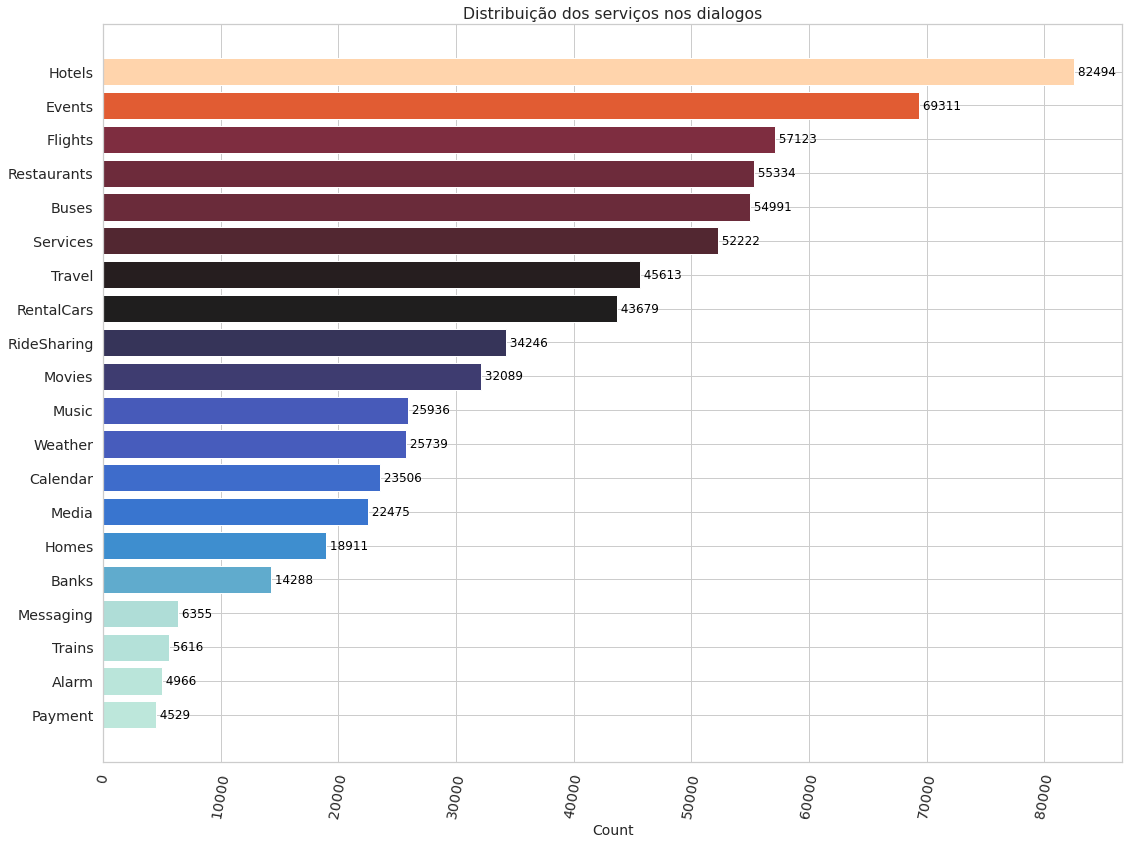

In [ ]:
services_count = df_service_exploded.groupby("services").count()
services_counter = Counter(services_count["dialogue_id"].to_dict())

plt.figure(figsize=(16, 12))
utils.plot_most_frequent_elements(services_counter,
                                  n_most_common=len(services_count),
                                  title='Distribuição dos serviços nos dialogos')

## Como estão distribuidos as sentenças entre usuário e sistema?

Abaixo, podemos ver que as sentenças estão bem distribuídas entre usuário e o sistema.

In [ ]:
# Separando as sentenças de acordo com o speaker
system_df = df[df["speaker"] == "SYSTEM"]
user_df = df[df["speaker"] == "USER"]

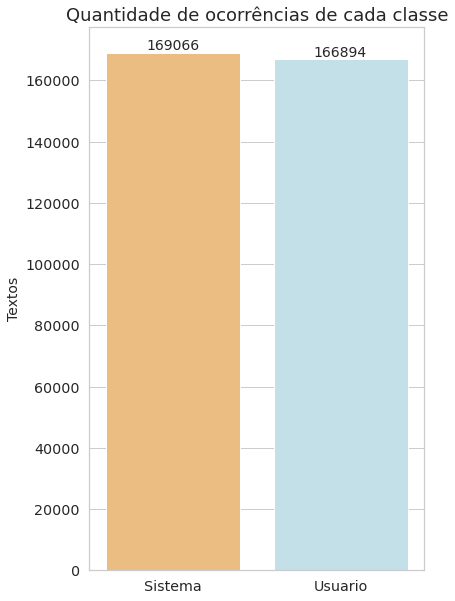

In [ ]:
classes = ['Sistema', 'Usuario']
classes_count = [len(system_df), len(user_df)]

utils.plot_histogram_labels(x_label=classes, 
                            y_label=classes_count, 
                            labels=classes_count, 
                            palette='RdYlBu',
                            title='Quantidade de ocorrências de cada classe', 
                            ylabel_title='Textos', 
                            width=6,
                            height=10, 
                            rotation=0)

## Quais as palavras mais comuns?

Para sabermos quais as palavras mais comuns presentes nos textos, primeiramente iremos obter algumas estatísticas básicas oriundas do processo de tokenização. Depois, examinaremos quais são as palavras mais comuns através de nuvens de palavras. 

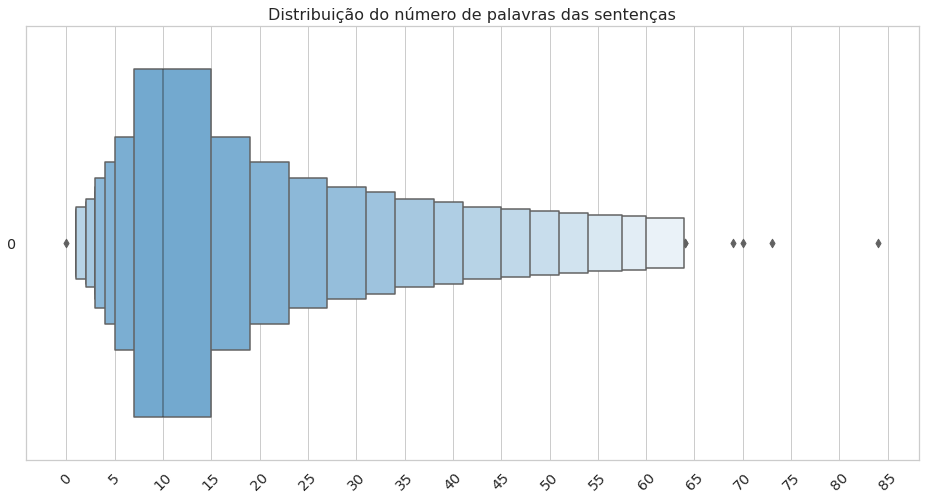

In [ ]:
# Tokenização simples e remoção de pontuações, e em lowercase para pegar as stopwords com diferentes formatos
token_count = [len(utils.tokenizer(text)) for text in df["utterance"]]

utils.plot_distribution_large_data(token_count, 
                                   title='Distribuição do número de palavras das sentenças', 
                                   xaxis_interval=5)

Observe que o gráfico acima exibe a quantidade de palavras dos textos dos diálogos. A grande maioria está concentrada no intervalo de 5 a 15 palavras, ou seja, o *Schema-Guided Dialogue Dataset* possui muitos textos curtos, com apenas uma ou duas frases.

E, como era de se esperar de um dado textual, as nuvens de palavras abaixo nos mostram o que já explicamos no 1º *notebook* de análise exploratória do *Wikipedia Toxic Comments dataset*.

Como vimos anteriormente, um dos serviços mais frequentes são relacionados a viagens, por isso, dentre as palavras mais frequentes, vemos várias palavras no contexto de viagens, como *flight*, *hotel*, *reservation* , além de eventos como *tickets* e *event*.

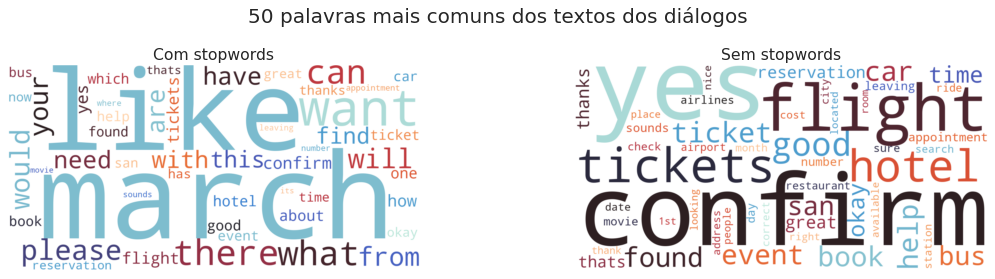

In [ ]:
words_clean_count = utils.count_tokens(df["utterance"])
words_count = utils.count_tokens(df["utterance"], remove_stopwords=False)

general_word_counts = {
   'Com stopwords': words_count,
   'Sem stopwords': words_clean_count
}
utils.plot_word_clouds(general_word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos', 
                       figsize=(16, 4))

## Quais são as palavras mais comuns por emissor?

Aqui, vamos analisar quais as palavras mais comuns de acordo com quem fala, ou seja, analisaremos as palavras mais comuns em textos dos usuários e do sistema.

Além das *stopwords*, também é interessante remover palavras que aparecem com grande frequência no texto, pois estas podem acabar impactando negativamente nos modelos.

A partir do gráfico de distribuição abaixo, é possível notar que a grande maioria das palavras ocorrem com frequência menor ou igual a 7000.

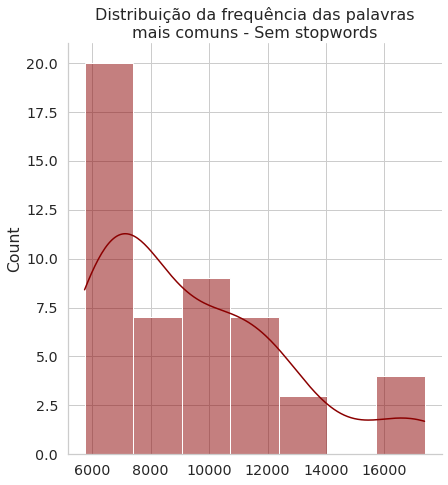

In [ ]:
most_common_tokens = Counter(words_clean_count)

sns.set(style='whitegrid', font_scale=1.3)
sns.displot(data=[tup[1] for tup in most_common_tokens.items()], kde=True, color='darkred', height=6.5)
plt.title('Distribuição da frequência das palavras\nmais comuns - Sem stopwords', fontsize=16)
plt.show()

Com isso, para uma melhor análise das palavras mais frequentes de cada emissor, optamos por ignorar as palavras que ocorrem mais do que 7000 vezes. Essa escolha é denotada pela linha vermelha traçada no gráfico abaixo: 

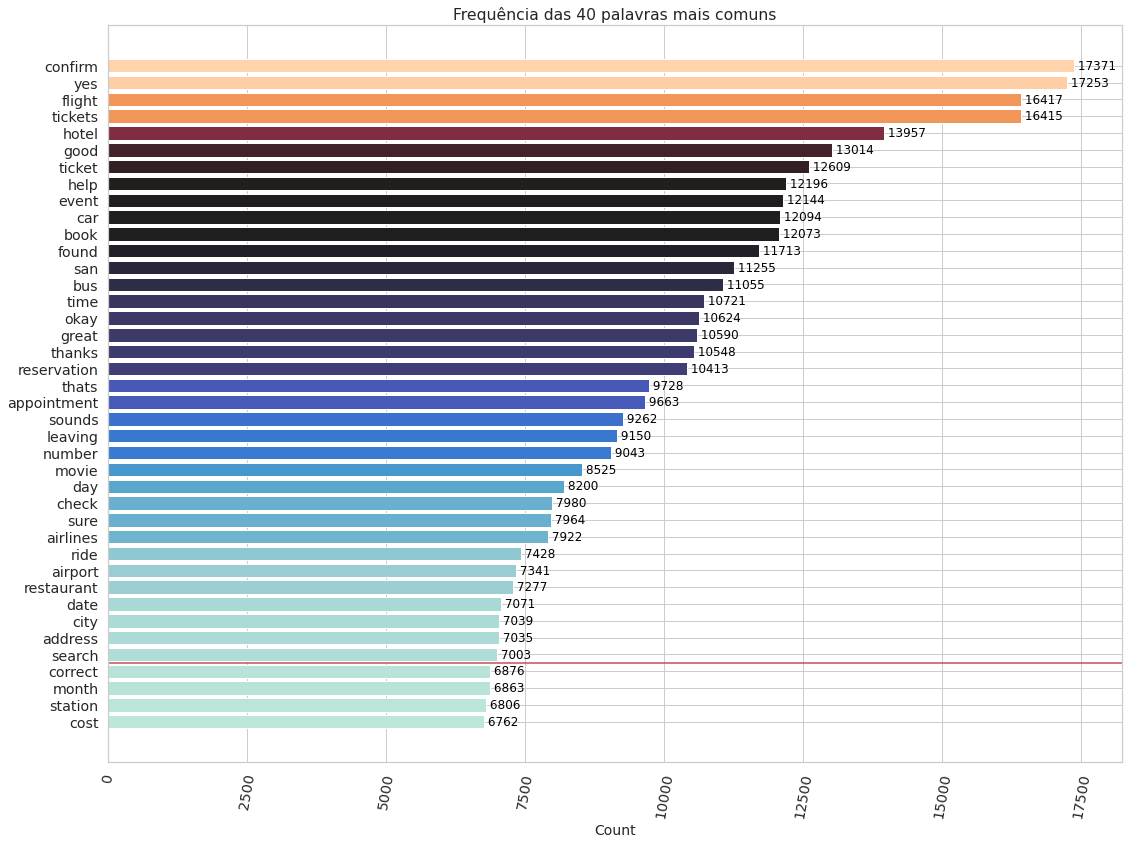

In [ ]:
plt.figure(figsize=(16, 12))
utils.plot_most_frequent_elements(most_common_tokens,
                                  n_most_common=40,
                                  title='Frequência das 40 palavras mais comuns')
plt.axhline(y=3.50, color='r', linestyle='-');

In [ ]:
frequency_cut = 7000
words2ignore = [tup[0] for tup in most_common_tokens.items() if tup[1] > frequency_cut]

system_words_count = utils.count_tokens(system_df["utterance"], n_most_common=50, to_ignore=words2ignore)
user_words_count = utils.count_tokens(user_df["utterance"], n_most_common=50, to_ignore=words2ignore)

print('Quantidade de palavras que devem ser ignoradas = {}'.format(len(words2ignore)))

Quantidade de palavras que devem ser ignoradas = 36


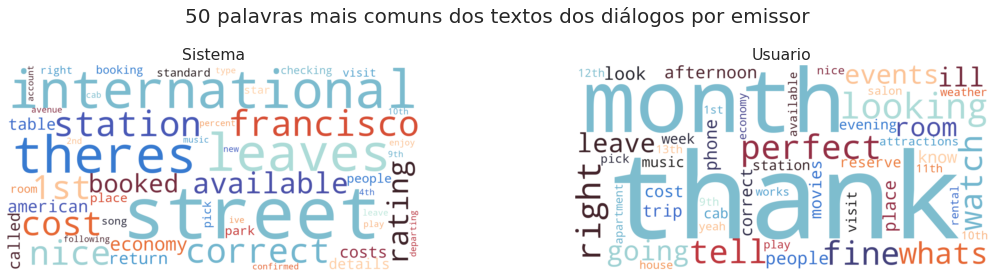

In [ ]:
word_counts = {
   'Sistema': system_words_count,
   'Usuario': user_words_count
}

utils.plot_word_clouds(word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos por emissor',
                       figsize=(16, 4))


Aqui, realmente vemos que do lado do sistema quem domina é o turismo, com diversas palavras relacionadas a viagens, como *airlines*, *international* e *airport*. Do lado do usuário, as palavras também vão na linha de viagens, contudo, vemos diversos agradecimentos, algo que não acontece em frases do sistema.

## Qual a quantidade de palavras ofensivas nos textos dos diálogos por emissor?

Aqui, tal como também foi feito no 1º *notebook* de EDA [[2]()], verificamos a presença de palavras ofensivas e de baixo calão com base no *List of Dirty, Naughty, Obscene, and Otherwise Bad Words* [[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)]. No entanto, verificando as nuvens de palavras por emissor, podemos dizer antecipadamente que estes termos não são tão frequentes. 

In [ ]:
def add_count(text):
  bad_words_count = utils.count_bad_words(text)
  return bad_words_count

system_df["bad_words_count"] = system_df["utterance"].map(add_count)
system_bad_words_count = system_df["bad_words_count"].sum()

user_df["bad_words_count"] = user_df["utterance"].map(add_count)
user_bad_words_count = user_df["bad_words_count"].sum()


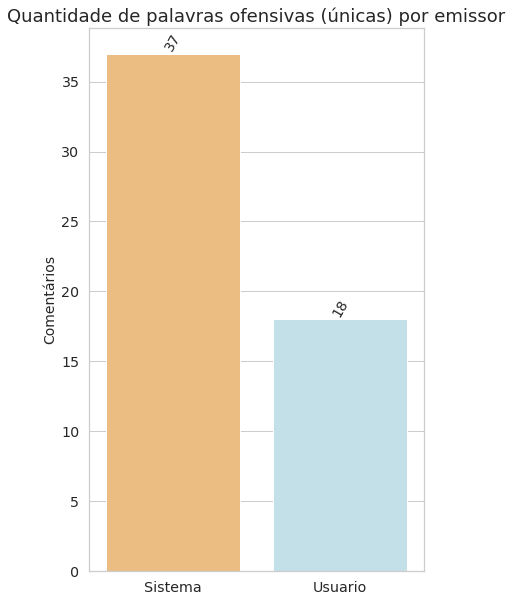

In [ ]:
bad_words_per_class = [
  system_bad_words_count,
  user_bad_words_count
]

utils.plot_histogram_labels(x_label=classes, 
                            y_label=bad_words_per_class, 
                            labels=bad_words_per_class, 
                            palette='RdYlBu',
                            title='Quantidade de palavras ofensivas (únicas) por emissor', 
                            ylabel_title='Comentários', 
                            width=6,
                            height=10)

É estranho que o sistema tenha dito mais palavras "ofensivas" que o usuário. Ao ver algumas dessas frases, vemos que pelo contexto não são frases ofensivas, apesar de conterem alguns termos frequentes em textos ofensivos, como "sex" e "Anu'S".

In [ ]:
list(system_df[system_df["bad_words_count"] > 0]["utterance"])

['How does Sex Metal Barbie by In This Moment off of their Black Widow sound?',
 'Sure, Maty Noyes has 1 song called New Friends in his album Love Songs From a Lolita. Would you like to hear it?',
 'There are 2 songs that suit you. What about Easy World from the album Sex Rock by Alex Angel',
 'What about My Donna from the album Sex Rock by Alex Angel?',
 'How about the song titled Whore by the band In This Moment, from the album Blood?',
 'No problem. So you want me to play the song Whore on the kitchen speaker, is that right?',
 'whore is on tv',
 'Okay, I have found a good song for you, Do you like Easy World by Alex Angel in the album Sex Rock?',
 'How about the Cindy Santos song Baby Sexy from the Try Again album?',
 'Confirming playback of Baby Sexy on the TV speaker.',
 'Confirming playback of Baby Sexy on the kitchen speaker.',
 'Confirming playback of Baby Sexy on the bedroom speaker.',
 'To confirm then I will play Sex Metal Barbie on the TV.',
 'Sure, please confirm your req

Similar a frases do sistema, ao analisar o contexto das frases onde aparecem palavras pejorativas, vemos que em sua maioria, não são frases que denotam ofensa, como nos nomes de albuns "*Sex Rock*" ou na musica "*Sex Metal Barbie*". Exceto por alguns exemplos onde podemos perceber uma certa raiva do usuário, como em "*Confirm that shit*".

In [ ]:
list(user_df[user_df["bad_words_count"] > 0]["utterance"])

['Yes i wank to make a reservation at 6 in the evening.',
 'Confirm that shit.',
 'I am in the mood to listen to Rock songs. Could you find me some songs from the album Sex Rock?',
 'That sucks, no that was it thank anyways though.',
 'Is tit a refundable ticket?',
 'whore is the song',
 'Thank you, I feel boring now, i need to listen some good songs. i like songs by Alex Angel, There are many good songs in the album Sex Rock, i Really like Rock song.',
 'Thanks for all that. Now could yoou assist me in listening to music. Put it on the television, Sex Metal Barbie or songs by In This Moment.',
 'I see, could you help me play Sex Metal Barbie in the album In This Moment on the speaker in the kitchen please?',
 'Could you play Sex Metal Barbie please?',
 'Whore please. It has a unique sound.',
 'Some funny shit.',
 'after works for me. can you find me a pop song. i like maty noyes, especially the love songs from a lolita album.',
 "I'll suck it up. Get me a reservation.",
 "Fine, since 

# Referências

[[1](https://arxiv.org/pdf/1909.05855.pdf)] Rastogi, A., Zang, X., Sunkara, S., Gupta, R. and Khaitan, P., 2020, April. Towards scalable multi-domain conversational agents: The schema-guided dialogue dataset. In *Proceedings of the AAAI Conference on Artificial Intelligence* (Vol. 34, No. 05, pp. 8689-8696).

[[2]()] Para o GitHub - Colocar aqui o link do notebook 1

[[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)] Our List of Dirty, Naughty, Obscene, and Otherwise Bad Words. 2020. *GitHub*. LDNOOBW.